## Stock Market Portfolio Prediction


Link to Google Drive and Copy Necessary File to Colab

In [ ]:
%matplotlib inline
colab = True

if colab==True:
    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir StockData
    %cp 'drive/My Drive/NCCU/1082_Deep Learning/FinalProject/kaggle_stock.zip' /content/
    !unzip -n /content/kaggle_stock.zip -d /content/StockData/
    # !pip uninstall plotly --yes
    # !pip install plotly==4.8.1
    data_folder = 'StockData/Stocks'
else:
    data_folder = f'F:/GoogleDrive/NCCU/1082_Deep Learning/FinalProject/kaggle_stock/Stocks'    

Import Module

 # -----------------Preprocess----------------

### Load & Pick Stock Data

Training Stock info 
 Stock : amzn 
 Trading Days : 5153


In [ ]:
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label
0,1997-05-16,1.97,1.98,1.71,1.73,14700000,0,amzn
1,1997-05-19,1.76,1.77,1.62,1.71,6106800,0,amzn
2,1997-05-20,1.73,1.75,1.64,1.64,5467200,0,amzn
3,1997-05-21,1.64,1.65,1.38,1.43,18853200,0,amzn
4,1997-05-22,1.44,1.45,1.31,1.40,11776800,0,amzn


### Plot Stock Data

## Calculate Technical Index Data

In [ ]:
techindi.describe()


,Open,High,Low,Close,Volume,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,AB_Upper_Band,AB_Lower_Band,STOK,STOD,Chaikin_MF,psar,ROC,VWAP,Momentum,CCI,OBV,Kelch_Upper,Kelch_Middle,Kelch_Down,TEMA,NATR,plusDI,minusDI,ADX,MACD,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span,WillR,MIN_Volume,MAX_Volume,KAMA
count,5153.000000,5153.000000,5153.000000,5153.000000,5.153000e+03,5153.000000,5.153000e+03,5153.000000,5153.000000,5153.000000,5153.000000,5.153000e+03,5153.000000,5153.000000,5153.000000,5153.000000,5153.000000,5153.000000,5153.000000,5153.000000,5153.000000,5153.000000,5153.000000,5.153000e+03,5153.000000,5153.000000,5153.000000,5.153000e+03,5153.000000,5153.000000,5153.000000,5153.000000,5153.000000,5153.000000,5153.000000,5153.000000,5153.000000,5153.000000,5153.000000,5153.000000,5.153000e+03,5.153000e+03,5153.000000
mean,181.747357,183.880652,179.466684,179.809095,7.837325e+06,53.321620,7.837325e+06,179.756915,185.832664,173.680805,13.070444,1.228480e+01,179.756735,190.796210,168.887816,26.848405,26.845603,0.942078,179.809095,3.011278,46.803963,0.789484,18.050112,1.657855e+09,184.088305,179.694997,175.301690,6.064983e+07,12.189420,10.291297,8.507673,35.176703,1.333311,53.529545,180.680694,179.063127,174.781972,172.003725,179.802088,-50.088468,3.973127e+06,1.706793e+07,179.698212
std,239.611052,241.226109,237.638139,235.822755,7.594745e+06,12.626502,7.594745e+06,236.287573,241.613168,231.054421,59.166571,1.539436e+06,236.287557,245.183871,227.393769,31.674041,24.745578,6.862603,235.822755,18.550582,22.549607,12.435363,94.096887,4.885002e+08,239.564479,235.975534,232.404503,1.805207e+08,8.239126,6.373242,4.963289,12.666804,6.201589,18.512328,237.677718,234.908987,229.092595,224.546192,235.828073,37.649469,2.495219e+06,1.551829e+07,236.019938
min,1.410000,1.450000,1.310000,1.310000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-96.000000,-2.227671e+07,0.000000,0.000000,0.000000,-58.973624,-45.354515,-52.562732,1.310000,-53.018182,1.553649,-98.303421,-245.585262,-7.018080e+07,0.000000,0.000000,0.000000,1.041463e+00,0.000000,0.000000,0.000000,0.000000,-37.764114,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-152.627941,0.000000e+00,0.000000e+00,0.000000
25%,35.500000,36.130000,35.000000,35.335872,3.779449e+06,44.784219,3.779449e+06,35.448000,37.104000,33.945000,-40.000000,-1.323281e+05,35.448000,38.943862,32.781234,2.294557,7.651454,-2.078564,35.335872,-6.929956,35.381700,-2.756096,-69.248621,1.482159e+09,36.913081,35.621620,34.481556,4.082671e+04,6.554542,6.066521,4.982882,25.914620,-0.930331,42.772692,35.450000,35.630000,35.270000,35.180000,35.335872,-85.440767,2.237571e+06,7.701300e+06,35.584692
50%,70.900000,72.750000,69.020000,70.778048,5.902992e+06,53.269537,5.902992e+06,70.956000,76.365000,65.883000,32.000000,-2.206058e+03,70.956500,81.920330,61.413195,28.982301,29.500845,0.847102,70.778048,1.708367,40.365494,0.438066,34.120650,1.741471e+09,75.155441,71.130541,67.191363,3.419991e+05,9.462406,8.970120,7.523138,33.253845,0.438695,51.160046,71.985000,72.655000,71.012500,71.920000,70.778048,-52.421524,3.542541e+06,1.166660e+07,70.979891
75%,242.850000,245.770000,240.670000,242.545689,8.888949e+06,61.645299,8.888949e+06,238.514000,246.043000,231.095000,64.000000,1.300381e+05,238.514000,252.315627,226.369894,52.630489,47.563497,3.790166,242.545689,10.405791,59.065579,4.334150,96.740669,1.946754e+09,243.104718,237.874632,232.732449,1.386668e+07,15.439390,12.812320,10.810892,43.088194,2.806722,64.891455,239.560000,236.865000,231.817500,228.730000,242.545689,-14.378749,4.967328e+06,2.024490e+07,240.181002
max,1126.100000,1135.540000,1124.060000,1083.310000,1.043288e+08,95.829713,1.043288e+08,1056.365000,1123.522000,992.388000,96.000000,2.812517e+07,1056.365000,1099.238809,1011.916309,93.750000,81.235146,61.271848,1083.310000,145.495550,112.153526,108.413681,260.793391,2.544684e+09,1071.814078,1053.224792,1034.6355

## Correation Heatmap

## Pick Columns by Correalation
Use full stock data's techinical index to caculate correalation </br>
Training by pick stock data

In [ ]:
# feature = corr['Close'][abs(corr['Close'])>0.3].index
# techindi = techindi[feature]

normalized_df = copy.deepcopy(techindi)
# normalized_df = normalized_df[normalized_df.index >= '2012-11-20'] # use 5 years stock data to train
# normalized_df = normalized_df.iloc[:,3:]

# ti_List = []
# x = normalized_df['Label'][0]
# ti_List.append(x)
# normalized_df = normalized_df.drop('Label', 1)
# max_value = normalized_df.max(axis = 0)
# normalized_df /= max_value
# normalized_df = normalized_df.fillna(0)    

def add_label(df):
    idx = len(df.columns)
    new_col = np.where(df['Close'] >= df['Close'].shift(1), 1, 0)  
    df.insert(loc=idx, column='Label', value=new_col)
    df = df.fillna(0)

add_label(normalized_df)    


 # ------------------Price-----------------

### Creating windows and normalizing the data


In [ ]:
# df = normalized_df
window_len = 10
zoom = 1

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(normalized_df.index[-(5*zoom*window_len):])[0] #5
split_date_2  = split_date+datetime.timedelta(days = window_len*4*zoom) #4

#Split the training and test set
training_set, valid_set, test_set = normalized_df[normalized_df.index < split_date], normalized_df[(normalized_df.index >= split_date) & (normalized_df.index < split_date_2)] ,normalized_df[normalized_df.index >= split_date_2]
training_set = training_set.drop(['Label'], 1)
valid_set = valid_set.drop(['Label'], 1)
test_set = test_set.drop(['Label'], 1)

#Create windows for training
LSTM_training_inputs = []
counter = 0
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in list(temp_set):
        if temp_set[col].iloc[0] !=0:
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)  ## each training dataframe base on window_len x len(columns)

LSTM_training_inputs_observe  = LSTM_training_inputs
# LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1
LSTM_training_outputs = training_set['Close'][window_len:].values
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs] # turn df to array
LSTM_training_inputs = np.array(LSTM_training_inputs)

#Create windows for valid
LSTM_valid_inputs = []
for i in range(len(valid_set)-window_len):
    temp_set = valid_set[i:(i+window_len)].copy()
    for col in list(temp_set):
        if temp_set[col].iloc[0] !=0:
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_valid_inputs.append(temp_set)  ## each valid dataframe base on window_len x len(columns)

# LSTM_valid_inputs_observe  = LSTM_valid_inputs
# LSTM_valid_outputs = (valid_set['Close'][window_len:].values/valid_set['Close'][:-window_len].values)-1
LSTM_valid_outputs = valid_set['Close'][window_len:].values
LSTM_valid_inputs = [np.array(LSTM_valid_input) for LSTM_valid_input in LSTM_valid_inputs] # turn df to array
LSTM_valid_inputs = np.array(LSTM_valid_inputs)

#Create windows for testing
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in list(temp_set):
        if temp_set[col].iloc[0] !=0:
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)

LSTM_test_inputs_observe  = LSTM_test_inputs
# LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1
LSTM_test_outputs = test_set['Close'][window_len:].values
LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [ ]:
print('original data date : ',len(normalized_df.index),'windows',min(normalized_df.index),max(normalized_df.index))
print('split date         : ','train/valid',split_date,'valid/test',split_date_2)
print('training data date : ',len(training_set.index),'windows',min(training_set.index),max(training_set.index))
print('valid data date    : ',len(valid_set.index),'windows',min(valid_set.index),max(valid_set.index))
print('test data date     : ',len(test_set.index),'windows',min(test_set.index),max(test_set.index))

original data date :  3333 windows 2004-08-19 00:00:00 2017-11-10 00:00:00
split date         :  train/valid 2017-09-01 00:00:00 valid/test 2017-10-11 00:00:00
training data date :  3283 windows 2004-08-19 00:00:00 2017-08-31 00:00:00
valid data date    :  27 windows 2017-09-01 00:00:00 2017-10-10 00:00:00
test data date     :  23 windows 2017-10-11 00:00:00 2017-11-10 00:00:00


### LSTM model definition


In [ ]:
def build_model(inputs, output_size, 
                activ_func="linear",
                dropout=0.10, 
                loss="mean_squared_error", 
                metrics = ['mean_squared_error'],
                optimizer="adam"):
    
    model = Sequential()
    model.add(LSTM(64,return_sequences=True,dropout=0.2,input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(GRU(64,dropout=0.2,recurrent_dropout=0.4,return_sequences=True)    )    
    model.add(LSTM(64,dropout=0.2))   
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

def build_model(inputs, output_size, 
                activ_func="linear",
                # dropout=0.10, 
                loss="mean_squared_error", 
                metrics = ['mean_squared_error'],
                optimizer="adam"):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    # model.add(Dropout(dropout))
    model.add(Dense(5,activation = activ_func))
    model.add(Dense(1))
    model.compile(loss=loss, optimizer = optimizer,metrics=metrics)
    # model.summary()
    return model

nn_model = build_model(LSTM_training_inputs, output_size=1)
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 256)           307200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 256)           525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 1)             257       
_________________________________________________________________
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 832,830
Trainable params: 832,830
Non-trainable params: 0
__________________________________________________

### Training of the LSTM model


#### Model Presetting

In [ ]:
cont = False
epochs = 20

model_label = 'amzn_llt'

model_name = "stock_model_{label}.h5".format(label = model_label)
model_folder = f"drive/My Drive/NCCU/1082_Deep Learning/FinalProject/model"
model_path = os.path.join(model_folder,model_name)

history_dataframe = 'stock_model_{}_history.csv'.format(model_label)
history_path = os.path.join(model_folder,history_dataframe)

print('Use {} data training'.format(stock_name),'\n')

Use amzn data training 



#### Training Model

In [ ]:
print('Use {} data training '.format(stock_name),'\n')

if cont == True:
    nn_model = tf.keras.models.load_model(model_path)
# initialise model architecture 
# model output is next price normalised to 10th previous closing price
history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                       validation_data = (LSTM_valid_inputs, LSTM_valid_outputs),
                       epochs=epochs, batch_size=1, verbose=1, shuffle=False)

tf.keras.models.save_model(nn_model, model_path)

history_dataframe = 'stock_model_{}_history.csv'.format(model_label)
history_path = os.path.join(model_folder,history_dataframe)

if cont:
    train_history = pd.DataFrame(history.history)
    train_history['Train_Stock'] = stock_name
    history_dataframe = pd.read_csv(history_path)
    history_dataframe = pd.concat([history_dataframe,train_history])
    history_dataframe = history_dataframe.reset_index(drop=True)
    history_dataframe.to_csv(history_path, index= False)
else:
    train_history = pd.DataFrame(history.history)
    history_dataframe = train_history
    history_dataframe['Train_Stock'] = stock_name
    history_dataframe.to_csv(history_path, index= False)
print()
print('model will save to : ', model_path)
print('history will save to : ', history_path)


Use amzn data training  

Epoch 1/20
5093/5093 [==============================] - 122s 24ms/step - loss: 282.6351 - mean_squared_error: 282.6351 - val_loss: 442.8464 - val_mean_squared_error: 442.8464
Epoch 2/20
5093/5093 [==============================] - 117s 23ms/step - loss: 2352.5281 - mean_squared_error: 2352.5281 - val_loss: 3094.5034 - val_mean_squared_error: 3094.5034
Epoch 3/20
5093/5093 [==============================] - 117s 23ms/step - loss: 2882.6045 - mean_squared_error: 2882.6045 - val_loss: 1171.0078 - val_mean_squared_error: 1171.0078
Epoch 4/20
5093/5093 [==============================] - 118s 23ms/step - loss: 2640.9236 - mean_squared_error: 2640.9236 - val_loss: 8508.4629 - val_mean_squared_error: 8508.4629
Epoch 5/20
5093/5093 [==============================] - 116s 23ms/step - loss: 2653.4187 - mean_squared_error: 2653.4187 - val_loss: 4929.8550 - val_mean_squared_error: 4929.8550
Epoch 6/20
5093/5093 [==============================] - 120s 24ms/step - loss: 2724

In [ ]:
model_history = pd.read_csv(history_path)
model_history

### Predict Model

Use amzn data testing  



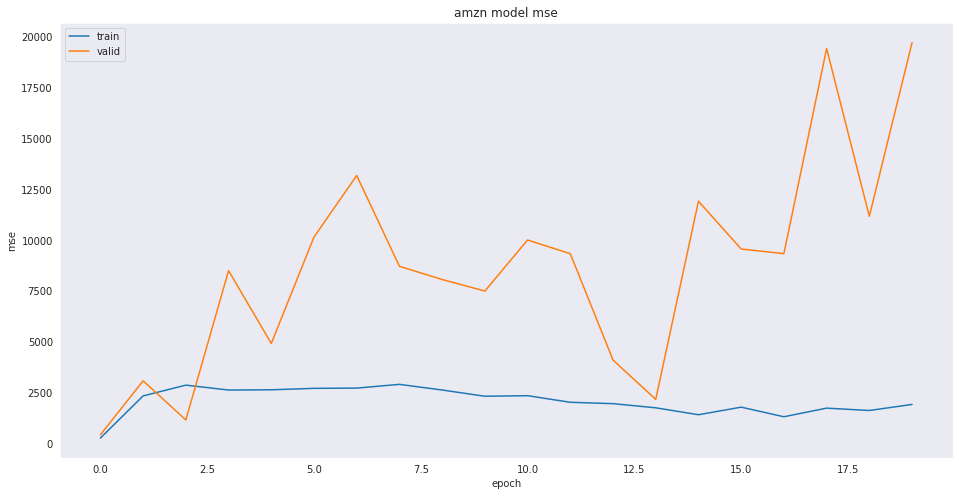

In [ ]:
model_history = pd.read_csv(history_path)

print('Use {} data testing '.format(stock_name),'\n')

sns.set_style("dark")
fig, ax = plt.subplots(1,1,figsize=(16,8))
for col in model_history.columns:
    if 'mean_squared_error' in col:
        ax = sns.lineplot(x=model_history.index , y=col ,data=model_history)

ax.set_title('{} model mse'.format(stock_name))
ax.set_xlabel ('epoch')
ax.set_ylabel ('mse')
ax.legend(['train', 'valid'], loc='upper left')


drive/My Drive/NCCU/1082_Deep Learning/FinalProject/model/stock_model_amzn_llt.h5
predict days 13


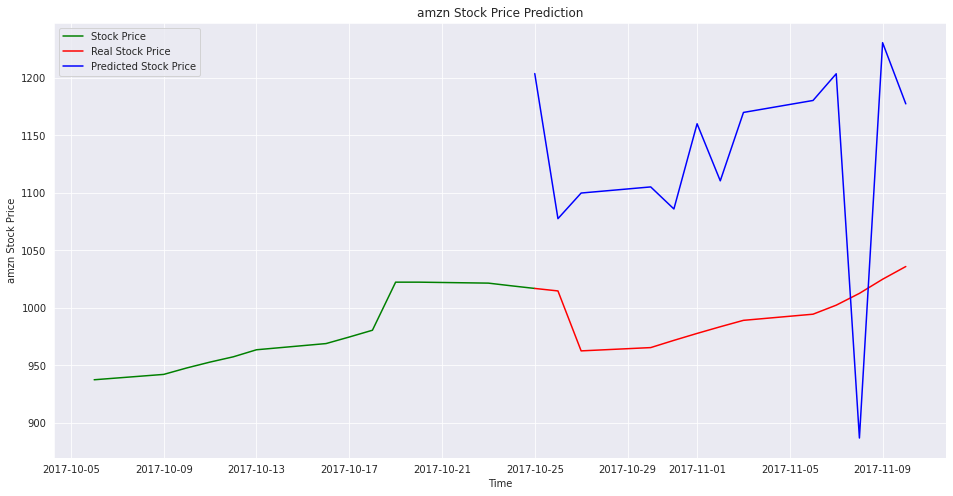

In [ ]:
nn_model = tf.keras.models.load_model(model_path)
print(model_path)
size = len(LSTM_test_outputs)
print('predict days',size)
predict = nn_model.predict(LSTM_test_inputs)
plt.figure(figsize=(16,8))
plt.plot(techindi.index[-size*2:-size+1], techindi['Close'].iloc[-size*2:-size+1], color='green', label = 'Stock Price')
plt.plot(techindi.index[-size:], LSTM_test_outputs, color = 'red', label = 'Real Stock Price')
plt.plot(techindi.index[-size:], predict, color = 'blue', label = 'Predicted Stock Price')
plt.title('{} Stock Price Prediction'.format(stock_name))
plt.xlabel('Time')
plt.ylabel('{} Stock Price'.format(stock_name))
plt.legend()
plt.grid(True)
# plt.savefig('lstm_30.pdf')
plt.show()

 # ------------------Trend-----------------

### Generator yielding timeseries samples and targets
Preparing the training, validation and test generators

In [ ]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=32, step=5):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][-1]
        yield samples, to_categorical(targets)

### Techindi X generator


In [ ]:
df_data = normalized_df.values

lookback = 5
step = 5
delay = 5
batch_size = 32

train_gen = generator(df_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=round(0.6*len(df_data)),
                      shuffle=False,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(df_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=round(0.6*len(df_data))+1,
                    max_index=round(0.8*len(df_data)),
                    step=step,
                    batch_size=batch_size)
test_gen = generator(df_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=round(0.8*len(df_data))+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (round(0.8*len(df_data)) - round(0.6*len(df_data))+1 - lookback) # how many steps to draw from val_gen in order to see the entire validation set
test_steps = (len(df_data) - round(0.8*len(df_data))+1 - lookback)



### Dropout-regularized GRU-based model

In [ ]:
def build_model(inputs,  
                activ_func="softmax",
                dropout=0.10, 
                loss="categorical_crossentropy", 
                metrics = ['accuracy'],
                optimizer=RMSprop()): 
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(None, inputs.shape[-1])))
    model.add(LSTM(256))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(layers.Dense(2, activation=activ_func))
    model.compile(loss=loss, optimizer = optimizer,metrics=metrics)
    # model.summary()
    return model

model = build_model(LSTM_training_inputs)
model.summary()

model = Sequential()
model.add(layers.LSTM(128,dropout=0.1,return_sequences=True,input_shape=(None, df_data.shape[-1])))
model.add(layers.LSTM(128,dropout=0.1))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, None, 256)         307200    
_________________________________________________________________
lstm_21 (LSTM)               (None, 256)               525312    
_________________________________________________________________
flatten_8 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 514       
Total params: 833,026
Trainable params: 833,026
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch=2,
                    epochs=10,
                    validation_data=val_gen,
                    validation_steps=val_steps)
test_loss, test_acc = model.evaluate_generator(test_gen, steps=3)
print('test acc:', test_acc)
print("test_loss:", test_loss)

Epoch 1/10
2/2 [==============================] - 2s 1s/step - loss: 0.6994 - accuracy: 0.4219 - val_loss: 0.6914 - val_accuracy: 0.5662
Epoch 2/10
2/2 [==============================] - 1s 670ms/step - loss: 0.6863 - accuracy: 0.6250 - val_loss: 0.6908 - val_accuracy: 0.5647
Epoch 3/10
2/2 [==============================] - 1s 677ms/step - loss: 0.6878 - accuracy: 0.5781 - val_loss: 0.6915 - val_accuracy: 0.5123
Epoch 4/10
2/2 [==============================] - 1s 667ms/step - loss: 0.7435 - accuracy: 0.2344 - val_loss: 0.6903 - val_accuracy: 0.4962
Epoch 5/10
2/2 [==============================] - 1s 668ms/step - loss: 1.0488 - accuracy: 0.5000 - val_loss: 0.6894 - val_accuracy: 0.5485
Epoch 6/10
2/2 [==============================] - 1s 686ms/step - loss: 0.6938 - accuracy: 0.4844 - val_loss: 0.6879 - val_accuracy: 0.5798
Epoch 7/10
2/2 [==============================] - 1s 670ms/step - loss: 0.7031 - accuracy: 0.4688 - val_loss: 0.6910 - val_accuracy: 0.5275
Epoch 8/10
2/2 [=======

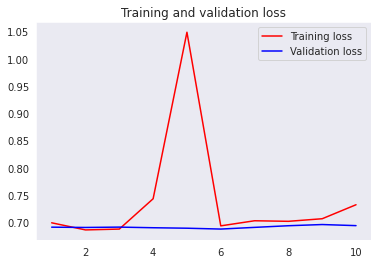

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

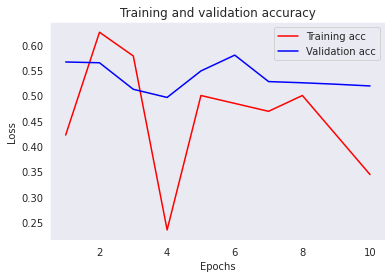

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

 # ------------------Price 2-----------------

In [ ]:
def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm

def train_windows(df, ref_day=5, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]["y"]))
    return np.array(X_train), np.array(Y_train)

def lstm_stock_model(shape):
    model = Sequential()
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5,activation='linear'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
    model.summary()
    return model

def build_model(trainX, trainy):
    verbose, epochs, batch_size = 0, 10, 32
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(trainX.shape[1],trainX.shape[2])))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(trainy.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model    

In [ ]:
train = techindi.dropna()
train['y'] = train['Close'].shift(-1)
train.iloc[:,:-1] = normalize(train.iloc[:,:-1])

train['Date'] = train.index
# train.reset_index(drop=True)
train['Date'] = pd.to_datetime(train['Date'], format='%Y%m%d')
train['weekday'] = train['Date'].apply(lambda x: x.day)
train['year'] = train['Date'].apply(lambda x: x.year)
train['Month'] = train['Date'].apply(lambda x: x.month)
test = train[-30:]
train = train[(train['year']==2017)|((train['year']==2018)&(train['Month']<=3))|((train['year']==2018)&(train['Month']==4)&(train['weekday']<=27))]
#train & test
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
train = train.dropna()

train.drop(['High','Low','Open','Date','weekday','year','Month'], axis=1, inplace=True)
test.drop(['Date','High','Low','Open','weekday','year','Month'], axis=1, inplace=True)
X_train, Y_train = train_windows(train, 15, 1)
X_test, Y_test = train_windows(test, 15, 1)
model = lstm_stock_model(X_train.shape)
# callback = EarlyStopping(monitor="mean_absolute_error", patience=10, verbose=1, mode="auto")



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 256)           304128    
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 256)           525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 15, 1)             257       
_________________________________________________________________
flatten (Flatten)            (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 80        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 829,783
Trainable params: 829,783
Non-trainable params: 0
__________________________________________________

In [ ]:
X_train[1]

array([[0.72489695, 0.02322675, 0.48570677, 0.02322675, 0.72405182,
        0.68670484, 0.76401266, 0.64583333, 0.44185693, 0.72405135,
        0.72149008, 0.72899793, 0.49882129, 0.29199553, 0.46542823,
        0.72489695, 0.29080684, 0.85633371, 0.44947686, 0.52528581,
        0.91222577, 0.7257455 , 0.72822125, 0.73078596, 0.39464841,
        0.0549027 , 0.09486064, 0.27710298, 0.20909721, 0.60200297,
        0.50147467, 0.68740691, 0.72408534, 0.74141499, 0.76778698,
        0.77821048, 0.54998405, 0.0821268 , 0.0501518 , 0.73661985],
       [0.72279259, 0.05528995, 0.58273819, 0.05528995, 0.72479588,
        0.68816632, 0.76394314, 0.64583333, 0.44527505, 0.72479588,
        0.72317058, 0.72806778, 0.91149653, 0.5890795 , 0.45726544,
        0.72279259, 0.2881004 , 0.857222  , 0.44165959, 0.66783677,
        0.9100198 , 0.72676939, 0.72898556, 0.73128137, 0.39181685,
        0.05369327, 0.25242109, 0.24015592, 0.21478001, 0.60094843,
        0.50199735, 0.68848682, 0.72408534, 0.7

In [ ]:
history_2 = model.fit(X_train, Y_train, epochs=20, batch_size=5, validation_split=0.2,shuffle=True)

Epoch 1/20
32/32 [==============================] - 3s 107ms/step - loss: 109.5741 - mean_absolute_error: 109.5741 - val_loss: 102.8899 - val_mean_absolute_error: 102.8899
Epoch 2/20
32/32 [==============================] - 3s 84ms/step - loss: 31.2039 - mean_absolute_error: 31.2039 - val_loss: 25.1637 - val_mean_absolute_error: 25.1637
Epoch 3/20
32/32 [==============================] - 3s 83ms/step - loss: 13.2805 - mean_absolute_error: 13.2805 - val_loss: 40.3179 - val_mean_absolute_error: 40.3179
Epoch 4/20
32/32 [==============================] - 3s 84ms/step - loss: 11.9766 - mean_absolute_error: 11.9766 - val_loss: 40.4841 - val_mean_absolute_error: 40.4841
Epoch 5/20
32/32 [==============================] - 3s 85ms/step - loss: 11.9985 - mean_absolute_error: 11.9985 - val_loss: 41.4778 - val_mean_absolute_error: 41.4778
Epoch 6/20
32/32 [==============================] - 3s 86ms/step - loss: 11.9969 - mean_absolute_error: 11.9969 - val_loss: 41.6690 - val_mean_absolute_error: 4

In [ ]:
X_train

In [ ]:
model = build_model(X_train,Y_train)
history_3 = model.fit(X_train, Y_train, epochs=5, batch_size=5, verbose=1)


Epoch 1/5
41/41 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 2/5
41/41 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 3/5
41/41 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 4/5
41/41 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 5/5
41/41 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


KeyError: ignored

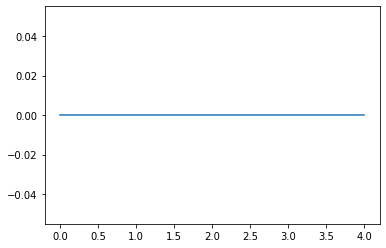

In [ ]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])

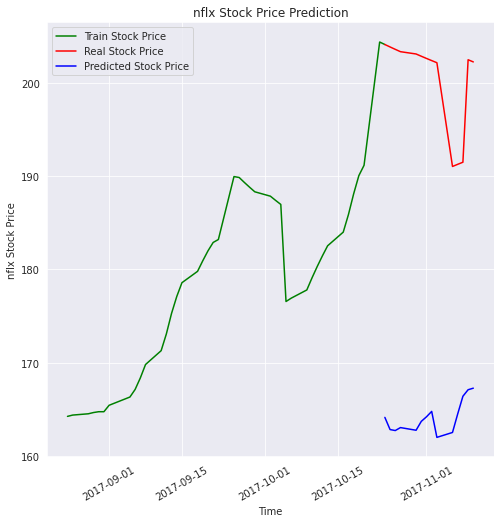

In [ ]:
predict = model.predict(X_test,batch_size=1)
# mean_squared_error(Y_test,predict)

size = len(Y_test)
predict_2 = model.predict(X_test,batch_size=1)

plt.figure(figsize=(8,8))
plt.plot(techindi.index[-size*4:-size+1], techindi['Close'].iloc[-size*4:-size+1], color='green', label = 'Train Stock Price')
plt.plot(techindi.index[-size:], Y_test, color = 'red', label = 'Real Stock Price')
plt.plot(techindi.index[-size:], predict_2, color = 'blue', label = 'Predicted Stock Price')
plt.title('{} Stock Price Prediction'.format(stock_name))
plt.xticks(rotation=30)
plt.xlabel('Time')
plt.ylabel('{} Stock Price'.format(stock_name))
plt.legend()
plt.grid(True)
# plt.savefig('lstm_30.pdf')
plt.show()